In [11]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the FAO dataset (replace with your dataset path)
df_fao = pd.read_csv('/Users/celinepham/Downloads/FAOSTAT_data_en_9-24-2024.csv')

# Define the cities and coordinates for weather data in India
cities = {
    'New Delhi': '28.6139,77.2090',
    'Mumbai': '19.0760,72.8777',
    'Kolkata': '22.5726,88.3639',
    'Chennai': '13.0827,80.2707',
    'Bangalore': '12.9716,77.5946'
}

# Initialize lists to store weather data for each year and city
weather_data = []

# Fetch weather data from NASA Power API for each city and year (2002-2022)
for year in range(2002, 2023):  # For the last 20 years
    for city, coordinates in cities.items():
        # NASA Power API URL
        url = f"https://power.larc.nasa.gov/api/temporal/daily/point?start={year}0101&end={year}1231&latitude={coordinates.split(',')[0]}&longitude={coordinates.split(',')[1]}&community=ag&parameters=T2M,QV2M,PRECTOT,ALLSKY_SFC_SW_DWN,WS10M&format=JSON"
        
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()

            # Extract parameters from the API response, checking if they exist
            temp_data = data['properties']['parameter'].get('T2M', {}).values()
            humidity_data = data['properties']['parameter'].get('QV2M', {}).values()
            precip_data = data['properties']['parameter'].get('PRECTOT', {}).values()  # Handle missing 'PRECTOT'
            solar_data = data['properties']['parameter'].get('ALLSKY_SFC_SW_DWN', {}).values()
            wind_data = data['properties']['parameter'].get('WS10M', {}).values()

            # Calculate average temperature, humidity, etc. for each year and city
            avg_temp = np.mean(list(temp_data)) if temp_data else None
            avg_humidity = np.mean(list(humidity_data)) if humidity_data else None
            avg_precip = np.mean(list(precip_data)) if precip_data else None
            avg_solar = np.mean(list(solar_data)) if solar_data else None
            avg_wind = np.mean(list(wind_data)) if wind_data else None

            weather_data.append([year, city, avg_temp, avg_humidity, avg_precip, avg_solar, avg_wind])
        else:
            print(f"Failed to fetch data for {city} in {year}, status code: {response.status_code}")

In [12]:
# Convert the collected weather data into a DataFrame
df_weather = pd.DataFrame(weather_data, columns=['Year', 'City', 'Average_Temperature', 'Average_Humidity', 'Average_Precipitation', 'Average_Solar_Radiation', 'Average_Wind_Speed'])

# Group the weather data by year and take the mean across cities for numeric columns only
df_weather_aggregated = df_weather.groupby('Year').agg({
    'Average_Temperature': 'mean',
    'Average_Humidity': 'mean',
    'Average_Precipitation': 'mean',
    'Average_Solar_Radiation': 'mean',
    'Average_Wind_Speed': 'mean'
}).reset_index()

# Check the available unique elements (agricultural, economic data) in the FAO dataset
print(df_fao['Element'].unique())

['Area harvested' 'Yield' 'Production' 'Stocks' 'Prod Popultn'
 'Producing Animals/Slaughtered' 'Laying' 'Yield/Carcass Weight'
 'Milk Animals']


In [13]:
# Pivot the FAO dataset to get relevant features (Area harvested, Production, Yield, Fertilizer Use, Irrigation)
df_fao_pivot = df_fao.pivot_table(index=['Year', 'Item'], 
                                  columns='Element', 
                                  values='Value', 
                                  aggfunc='mean').reset_index()

# Print the column names to understand what was generated
print(df_fao_pivot.columns)

Index(['Year', 'Item', 'Area harvested', 'Laying', 'Milk Animals',
       'Prod Popultn', 'Producing Animals/Slaughtered', 'Production', 'Stocks',
       'Yield', 'Yield/Carcass Weight'],
      dtype='object', name='Element')


In [14]:
# Keep only the relevant columns
df_fao_pivot = df_fao_pivot[['Year', 'Item', 'Area harvested', 'Production', 'Yield']]

# Rename the columns for better understanding
df_fao_pivot.columns = ['Year', 'Item', 'Area_Harvested', 'Production', 'Yield']

# Display the updated columns
print(df_fao_pivot.head())

   Year                                               Item  Area_Harvested  \
0  1961  Anise, badian, coriander, cumin, caraway, fenn...         90000.0   
1  1961                                             Apples         44500.0   
2  1961                                           Apricots          2900.0   
3  1961                                         Areca nuts        135000.0   
4  1961                                              Asses             NaN   

   Production    Yield  
0     45000.0   5000.0  
1    185000.0  41573.0  
2      8000.0  27586.0  
3    120000.0   8889.0  
4         NaN      NaN  


In [15]:
# Merge the FAO data with weather data
df_final = pd.merge(df_fao_pivot, df_weather_aggregated, on='Year', how='inner')

# Display the first few rows of the merged dataset
print(df_final.head())

# Define the independent variables (X) and dependent variable (Y)
X = df_final[['Average_Temperature', 'Average_Humidity', 'Average_Precipitation', 
              'Average_Solar_Radiation', 'Average_Wind_Speed', 'Area_Harvested', 
              'Production']]
Y = df_final['Yield']

   Year                                               Item  Area_Harvested  \
0  2002  Anise, badian, coriander, cumin, caraway, fenn...        547028.0   
1  2002                                             Apples        240000.0   
2  2002                                           Apricots          3603.0   
3  2002                                         Areca nuts        290000.0   
4  2002                                              Asses             NaN   

   Production    Yield  Average_Temperature  Average_Humidity  \
0    162362.0   2968.0            26.354822         13.372121   
1   1160000.0  48333.0            26.354822         13.372121   
2     10216.5  28355.0            26.354822         13.372121   
3    400000.0  13793.0            26.354822         13.372121   
4         NaN      NaN            26.354822         13.372121   

  Average_Precipitation  Average_Solar_Radiation  Average_Wind_Speed  
0                   NaN                18.453929             3.66137 

In [16]:
df_final['Yield'].fillna(df_final['Yield'].mean(), inplace=True)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the independent variables (X) and dependent variable (Y)
X = df_final[['Average_Temperature', 'Average_Humidity', 'Average_Precipitation', 
              'Average_Solar_Radiation', 'Average_Wind_Speed', 'Area_Harvested', 
              'Production']]
Y = df_final['Yield']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, Y_train)

# Predict the crop yield on the test set
Y_pred_rf = rf_model.predict(X_test)

# Evaluate the model's performance
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)

print(f"Random Forest Mean Squared Error: {mse_rf}")
print(f"Random Forest R-squared: {r2_rf}")

Random Forest Mean Squared Error: 263630153.05588877
Random Forest R-squared: 0.9701736678909791


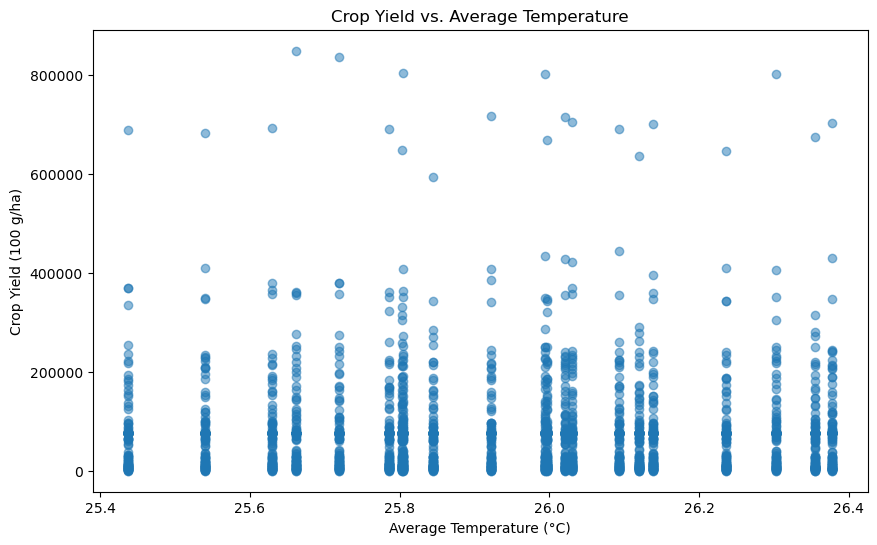

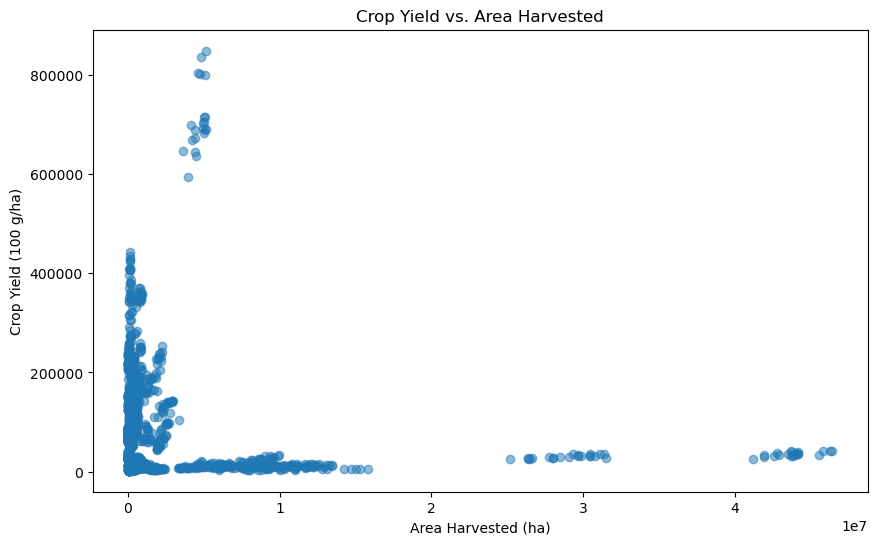

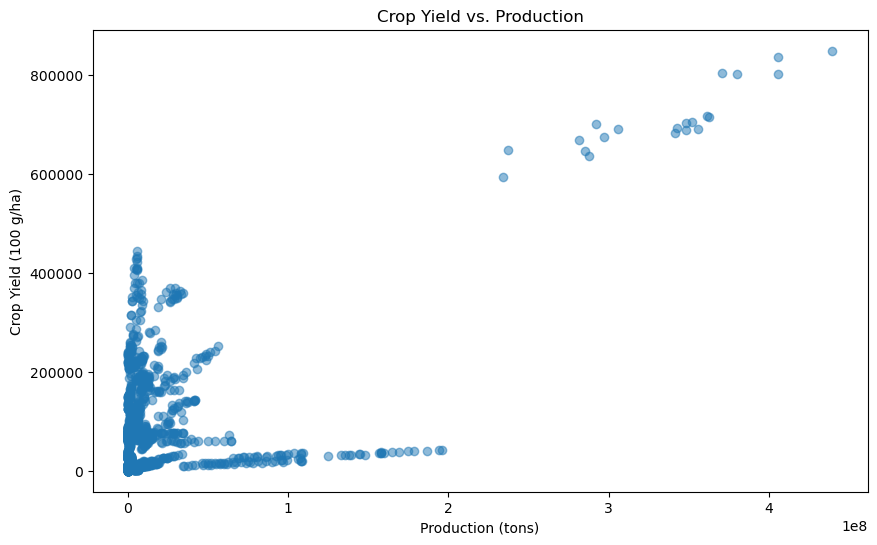

In [18]:
# Plot the relationships between crop yield and key variables
plt.figure(figsize=(10, 6))
plt.scatter(df_final['Average_Temperature'], df_final['Yield'], alpha=0.5)
plt.title('Crop Yield vs. Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Crop Yield (100 g/ha)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['Area_Harvested'], df_final['Yield'], alpha=0.5)
plt.title('Crop Yield vs. Area Harvested')
plt.xlabel('Area Harvested (ha)')
plt.ylabel('Crop Yield (100 g/ha)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_final['Production'], df_final['Yield'], alpha=0.5)
plt.title('Crop Yield vs. Production')
plt.xlabel('Production (tons)')
plt.ylabel('Crop Yield (100 g/ha)')
plt.show()

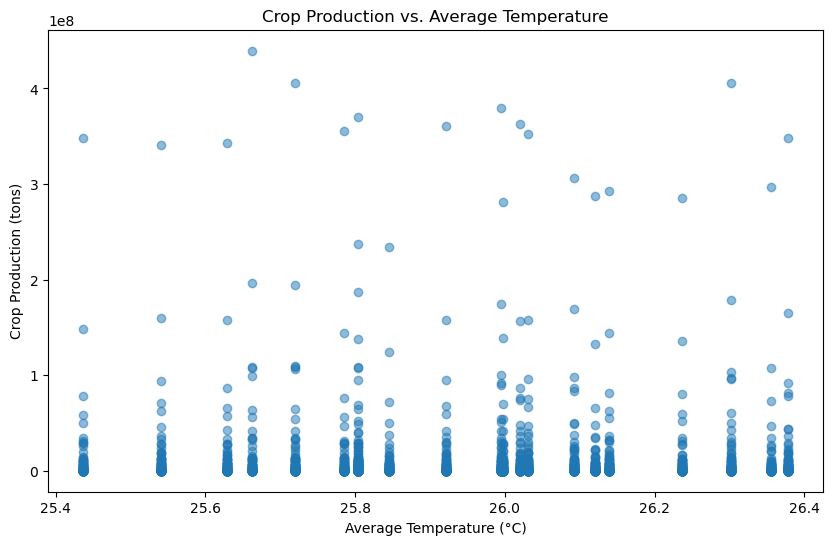

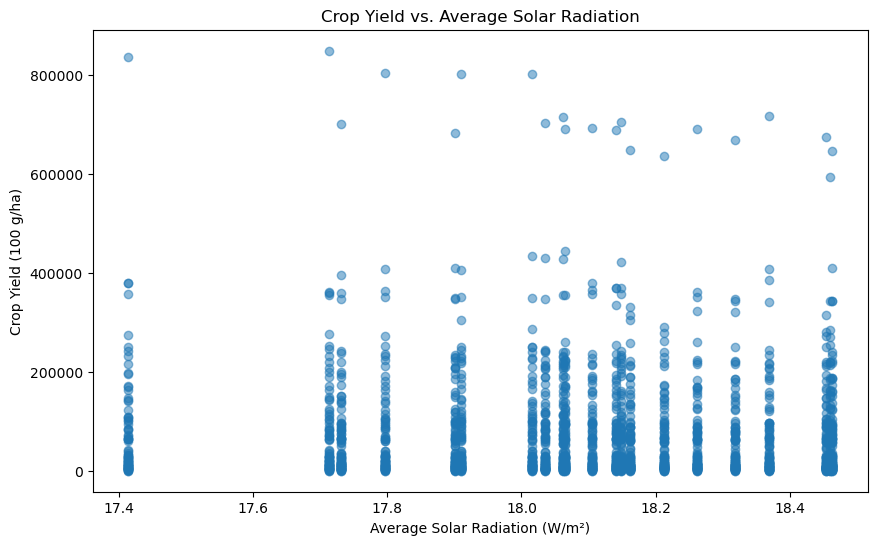

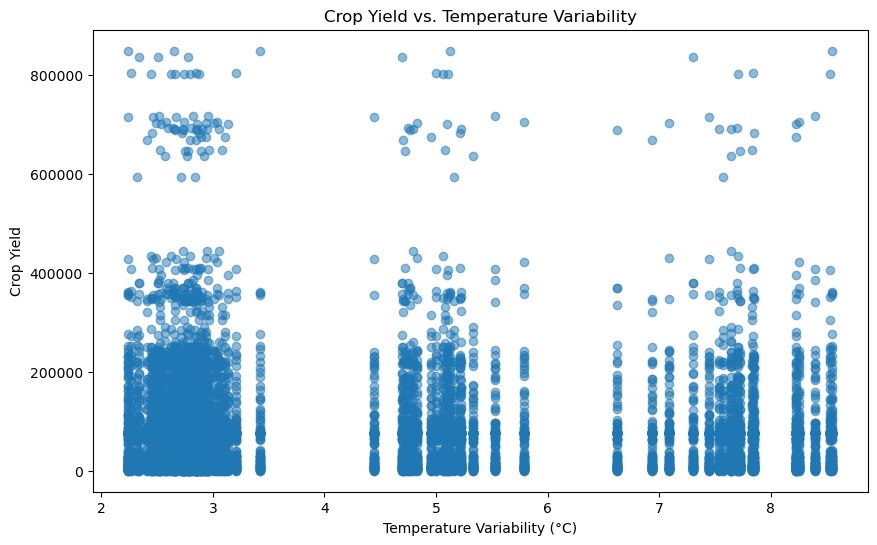

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(df_final['Temperature_Variability'], df_final['Yield'], alpha=0.5)
plt.title('Crop Yield vs. Temperature Variability')
plt.xlabel('Temperature Variability (°C)')
plt.ylabel('Crop Yield')
plt.show()